In [3]:
import re
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from geopy import distance

In [4]:
# This line uses the glob library to find all directories matching the specified path, and sorts them alphabetically.
# The resulting list contains the full file path to each directory.
folders = sorted(glob.glob('D:/MELA/Test Dataset SRT/SM_Lek1/*'))

# This sets the drift threshold to 5 metres. The drift threshold is used later in the code to determine whether or not
# a GPS coordinate drifts too far from the average coordinate of a section of a trajectory.
drift_thresh = 5
height_thresh = 7

In [5]:
def extract_data_from_srt(file_path):
    """
    Extracts data from a SubRip subtitle file.

    Args:
        file_path (str): The path to the subtitle file.

    Returns:
        pandas.DataFrame: A DataFrame containing the extracted data.
    """
    with open(file_path, 'r') as f:
        content = f.read()
    # Use regular expressions to extract the frame number, timestamp, latitude, longitude, and altitude from each frame
    frames = re.findall(r'(\d+)\n.*?(\d{2}:\d{2}:\d{2},\d{3},\d{3}).*?\[latitude:\s*([-+]?\d+\.\d+)\]\s*\[longitude:\s*([-+]?\d+\.\d+)\]\s*\[altitude:\s*([-+]?\d+\.\d+)\]', content, re.DOTALL)
    # Convert the extracted data into a list of dictionaries, where each dictionary represents one frame
    results = [{'frame': int(frame), 'timestamp': str(timestamp), 'latitude': float(latitude), 'longitude': float(longitude), 'altitude': float(altitude)} for frame, timestamp, latitude, longitude, altitude in frames]
    # Convert the list of dictionaries into a pandas DataFrame and return it
    return pd.DataFrame(results)


def geodist(coord1, coord2_lat, coord2_long):
    """
    Computes the geodesic distance between two geographic coordinates.

    Args:
        coord1 (tuple): A tuple representing the first coordinate, in the format (latitude, longitude).
        coord2_lat (float): The latitude of the second coordinate.
        coord2_long (float): The longitude of the second coordinate.

    Returns:
        float: The geodesic distance between the two coordinates, in metres.
    """
    return distance.distance(coord1, (coord2_lat, coord2_long)).m

In [6]:
# Create an empty list to store dataframes
df_list = []

# Create an empty list to store maximum drift distance from mean drone position
dist_max = []

# Create an empty list to store the drift status
drift_status = []
# Create an empty list to store the height status
height_status = []

# Loop through each folder
for folder in folders:
    
    # Get all .SRT files in the folder
    files = sorted(glob.glob(folder + '/*.SRT'))
    
    # Loop through each file
    for file in files:
        
        # Extract data from the .SRT file
        df_rec = extract_data_from_srt(file)
        
        
            
        #WORKING ON ALTITUDE TO FIND RELAY   
        
        # Create a new column with value 80
        df_rec['normal_altitude'] = 80.0
        
        #Create a new column to find the variation in altitude from 80
        df_rec['height_difference'] = df_rec['altitude'] - df_rec['normal_altitude']
        
        # Compute if the diffence in altitude is higher than the threshold mentioned above
        if df_rec['height_difference'].max() > height_thresh:
            height_status.append(1)  # Drift above height_thresh
        else:
            height_status.append(0)  # Drift below or equal to height_thresh
            
        #WORKING ON DRIFT
        
        # Compute the mean coordinate from the filtered dataframe
        coord1 = (df_rec['latitude'].mean(), df_rec['longitude'].mean())
        
        # Compute the distance of each point from the mean coordinate and store it in a new column
        df_rec['distance'] = df_rec.apply(lambda row: geodist(coord1, row.latitude, row.longitude), axis=1)
        
        # Compute if the fifference in cordinates is higher than the threshold mentioned above
        if df_rec['distance'].max() > drift_thresh:
            drift_status.append(1)  # Drift above 5m
        else:
            drift_status.append(0)  # Drift below or equal to 5m
            
        # Extract start and end timestamps
        start_ts = df_rec['timestamp'].iloc[0]
        end_ts = df_rec['timestamp'].iloc[-1]
        
        # Append folder, file, start and end timestamps to the dataframe list
        df_list.append({
            'folder': folder[-4:],  # Only include the last 4 characters of the folder name
            'Video_ID': file[-12:-4],  # Only include the last 8 characters of the file name (without the .SRT extension)
            'start_timestamp': start_ts,
            'end_timestamp': end_ts,
            'maximum height': df_rec['altitude'].max()  # Assign the maximum altitude value to the 'maximum height' column
        })
        
    
    
# Create the final dataframe from the list of dictionaries
df_day = pd.DataFrame(df_list)
# Add the 'drift_status' column to the df_day DataFrame
df_day['drift_status'] = drift_status
# Add the 'flight_status' column to the df_day DataFrame
df_day['Relay video'] = height_status



In [7]:
df_day['position'] = df_day['folder'].str[:2]  # Extract first 2 letters into 'position' column
df_day['drone'] = df_day['folder'].str[2:]  # Extract last 2 letters into 'drone' column

# Rearrange the columns to match the desired position
df_day = df_day[['Video_ID','position', 'drone', 'start_timestamp', 'end_timestamp', 'Relay video', 'drift_status', 'maximum height']]


In [8]:
# FINDING THE MISSING DATA 
positions = ['P1', 'P2', 'P3']

dfs = {}

for position in positions:
    df_p = df_day[df_day['position'] == position]
    
    # Remove the comma before microseconds
    df_p['start_timestamp'] = df_p['start_timestamp'].str.replace(',', '')
    df_p['end_timestamp'] = df_p['end_timestamp'].str.replace(',', '')

    # Convert the timestamp columns to datetime type
    df_p['start_timestamp'] = pd.to_datetime(df_p['start_timestamp'], format='%H:%M:%S%f')
    df_p['end_timestamp'] = pd.to_datetime(df_p['end_timestamp'], format='%H:%M:%S%f')

    # Shift the values in the "end_timestamp" column by one row
    df_p['previous_end_timestamp'] = df_p['end_timestamp'].shift(1)

    # Calculate the time difference and store the absolute value in the "end_start_diff" column
    df_p['end_start_diff'] = (df_p['previous_end_timestamp'] - df_p['start_timestamp']).dt.total_seconds().abs()

    # Remove the unnecessary column
    df_p = df_p.drop('previous_end_timestamp', axis=1)

    # To remove NAN of the last row
    df_p['end_start_diff'] = df_p['end_start_diff'].fillna(0)
    
    # Create the 'error' column and initialize it with 0
    df_p['error'] = 0

    # Set the 'error' values based on the condition
    df_p.loc[(df_p['end_start_diff'] > 1) & (df_p['end_start_diff'] < 600), 'error'] = 1
     
    # Convert the "error" column to integer type
    df_p['error'] = df_p['error'].astype(int)
    
    # Merge the data from error and Miss click

    df_day.loc[df_p.index, 'Miss click'] = df_p['error'].values
    
    # Remove the dates from the timestamp columns
    df_p['start_timestamp'] = df_p['start_timestamp'].dt.time
    df_p['end_timestamp'] = df_p['end_timestamp'].dt.time
    
    # Store the DataFrame in the dictionary
    dfs[position] = df_p.copy()

# Create separate DataFrames for P1, P2, and P3
df_p1 = dfs['P1']
df_p2 = dfs['P2']
df_p3 = dfs['P3']


# Print the updated DataFrame
print(df_day)

     Video_ID position drone   start_timestamp     end_timestamp  Relay video  \
0    DJI_0344       P1    D1  17:01:36,229,817  17:04:49,745,597            0   
1    DJI_0345       P1    D1  17:04:49,812,320  17:08:03,795,268            0   
2    DJI_0346       P1    D1  17:08:03,861,994  17:11:17,711,485            0   
3    DJI_0347       P1    D1  17:11:17,778,214  17:14:31,760,957            0   
4    DJI_0348       P1    D1  17:14:31,827,686  17:14:58,719,688            0   
..        ...      ...   ...               ...               ...          ...   
96   DJI_0978       P3    D6  18:06:19,419,955  18:08:07,420,747            0   
97   DJI_0979       P3    D6  18:25:09,306,130  18:28:22,920,058            1   
98   DJI_0980       P3    D6  18:28:22,986,789  18:31:36,934,355            0   
99   DJI_0981       P3    D6  18:31:37,001,084  18:34:50,848,550            0   
100  DJI_0982       P3    D6  18:34:50,915,280  18:37:09,511,214            0   

     drift_status  maximum 

C:\Users\user\AppData\Local\Temp\ipykernel_8164\917219349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p['start_timestamp'] = df_p['start_timestamp'].str.replace(',', '')
C:\Users\user\AppData\Local\Temp\ipykernel_8164\917219349.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p['end_timestamp'] = df_p['end_timestamp'].str.replace(',', '')
C:\Users\user\AppData\Local\Temp\ipykernel_8164\917219349.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [9]:
#FINDING THE FLIGHT NUMBER
#for the first set of drones
positions = ['P1', 'P2', 'P3']
drones = ['D1', 'D3', 'D5']

dfs = {}

for position in positions:
    for drone in drones:
        df_p = df_day[(df_day['position'] == position) & (df_day['drone'] == drone)]
        
        if not df_p.empty:  # Check if the DataFrame is not empty
            
            # Remove the comma before microseconds
            df_p['start_timestamp'] = df_p['start_timestamp'].str.replace(',', '')
            df_p['end_timestamp'] = df_p['end_timestamp'].str.replace(',', '')

            # Convert the timestamp columns to datetime type
            df_p['start_timestamp'] = pd.to_datetime(df_p['start_timestamp'], format='%H:%M:%S%f')
            df_p['end_timestamp'] = pd.to_datetime(df_p['end_timestamp'], format='%H:%M:%S%f')

            # Shift the values in the "start_timestamp" column by one row
            df_p['previous_end_timestamp'] = df_p['end_timestamp'].shift(1)

            # Calculate the time difference and store the absolute value in the "end_start_diff" column
            df_p['end_start_diff'] = (df_p['start_timestamp'] - df_p['previous_end_timestamp']).dt.total_seconds().abs()

            # Remove the unnecessary column
            df_p = df_p.drop('previous_end_timestamp', axis=1)

            # To remove NAN of the last row
            df_p['end_start_diff'] = df_p['end_start_diff'].fillna(0)

            # FINDING THE SORTIE NUMBER
            # Initialize the sortie column with 1
            df_p['sortie'] = 0

            # Set the sortie values based on the condition
            sortie_count = 0
            for index, row in df_p.iterrows():
                if pd.notnull(row['end_start_diff']) and row['end_start_diff'] > 600:
                    sortie_count += 2
                df_p.at[index, 'sortie'] = sortie_count + 1

            
            # Convert the "sortie" column to integer type
            df_p['sortie'] = df_p['sortie'].astype(int)

            # Merge the data from "sortie" column of df_p to "flight number" column of df_day
            df_day.loc[df_p.index, 'flight number'] = df_p['sortie'].values

            # Remove the dates from the timestamp columns
            df_p['start_timestamp'] = df_p['start_timestamp'].dt.time
            df_p['end_timestamp'] = df_p['end_timestamp'].dt.time

            # Store the DataFrame in the dictionary
            dfs[(position, drone)] = df_p.copy()

# Create separate DataFrames for P1, P2, and P3
df_P1D1 = dfs[('P1', 'D1')]
df_P2D3 = dfs[('P2', 'D3')]
df_P3D5 = dfs[('P3', 'D5')]

#For the second set of drones
positions = ['P1', 'P2', 'P3']
drones = ['D2', 'D4', 'D6']

dfs = {}

for position in positions:
    for drone in drones:
        df_p = df_day[(df_day['position'] == position) & (df_day['drone'] == drone)]
        
        if not df_p.empty:  # Check if the DataFrame is not empty
            
            # Remove the comma before microseconds
            df_p['start_timestamp'] = df_p['start_timestamp'].str.replace(',', '')
            df_p['end_timestamp'] = df_p['end_timestamp'].str.replace(',', '')

            # Convert the timestamp columns to datetime type
            df_p['start_timestamp'] = pd.to_datetime(df_p['start_timestamp'], format='%H:%M:%S%f')
            df_p['end_timestamp'] = pd.to_datetime(df_p['end_timestamp'], format='%H:%M:%S%f')

            # Shift the values in the "start_timestamp" column by one row
            df_p['previous_end_timestamp'] = df_p['end_timestamp'].shift(1)

            # Calculate the time difference and store the absolute value in the "end_start_diff" column
            df_p['end_start_diff'] = (df_p['start_timestamp'] - df_p['previous_end_timestamp']).dt.total_seconds().abs()

            # Remove the unnecessary column
            df_p = df_p.drop('previous_end_timestamp', axis=1)

            # To remove NAN of the last row
            df_p['end_start_diff'] = df_p['end_start_diff'].fillna(0)

            # FINDING THE SORTIE NUMBER
            # Initialize the sortie column with 1
            df_p['sortie'] = 0

            # Set the sortie values based on the condition
            sortie_count = 0
            for index, row in df_p.iterrows():
                if pd.notnull(row['end_start_diff']) and row['end_start_diff'] > 600:
                    sortie_count += 2
                df_p.at[index, 'sortie'] = sortie_count + 2

            # Convert the "sortie" column to integer type
            df_p['sortie'] = df_p['sortie'].astype(int)


            # Merge the data from "sortie" column of df_p to "flight number" column of df_day
            df_day.loc[df_p.index, 'flight number'] = df_p['sortie'].values

            # Remove the dates from the timestamp columns
            df_p['start_timestamp'] = df_p['start_timestamp'].dt.time
            df_p['end_timestamp'] = df_p['end_timestamp'].dt.time

            # Store the DataFrame in the dictionary
            dfs[(position, drone)] = df_p.copy()

# Create separate DataFrames for P1, P2, and P3
df_P1D2 = dfs[('P1', 'D2')]
df_P2D3 = dfs[('P2', 'D4')]
df_P3D5 = dfs[('P3', 'D6')]

C:\Users\user\AppData\Local\Temp\ipykernel_8164\2070271511.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p['start_timestamp'] = df_p['start_timestamp'].str.replace(',', '')
C:\Users\user\AppData\Local\Temp\ipykernel_8164\2070271511.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p['end_timestamp'] = df_p['end_timestamp'].str.replace(',', '')
C:\Users\user\AppData\Local\Temp\ipykernel_8164\2070271511.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [10]:
#FINDING COMMON START AND END TIME POINT AND PRINTING IN CSV
# Create a list to hold the start times of all three DataFrames
start_times = []

# Loop through each DataFrame and get the maximum value of the first row's start_timestamp column
for df in [df_p1, df_p2, df_p3]:
    start_times.append(df.iloc[0]['start_timestamp'])

# Find the maximum value among the three common start times
common_start_time = max(start_times)

# Create a list to hold the end times of all three DataFrames
end_times = []

# Loop through each DataFrame and get the minimum value of the last row's end_timestamp column
for df in [df_p1, df_p2, df_p3]:
    end_times.append(df.iloc[-1]['end_timestamp'])

# Find the minimum value among the three common end times
common_end_time = min(end_times)

# Assign values to the first row of the new columns
df_day.loc[0, 'Common start time'] = common_start_time
df_day.loc[0, 'Common end time'] = common_end_time

#Assign 0 to rest of the rows
df_day['Common start time'].iloc[1:] = pd.to_datetime(0)
df_day['Common end time'].iloc[1:] = pd.to_datetime(0)

# Convert 'Common start time' and 'Common end time' columns to datetime
df_day['Common start time'] = pd.to_datetime(df_day['Common start time'].astype(str))
df_day['Common end time'] = pd.to_datetime(df_day['Common end time'].astype(str))
df_day.loc[1:, 'Common start time'] = pd.to_datetime(0)
df_day.loc[1:, 'Common end time'] = pd.to_datetime(0)

# Remove date part from 'Common start time' column and 'Common end time' column where value is not 0
df_day['Common start time'] = df_day['Common start time'].apply(lambda x: x.time() if type(x) == pd.Timestamp else x)
df_day['Common end time'] = df_day['Common end time'].apply(lambda x: x.time() if type(x) == pd.Timestamp else x)

#TO MAKE SURE CSV FILE IS NOT ROUNDED UP FOR COMMON START AND END TIME

# Function to format time strings to "hours:minutes:seconds,microseconds" format
def format_common_time(time_obj):
    time_str = str(time_obj)  # Convert datetime.time object to string
    hours, minutes, seconds = time_str.split(":")
    
    # Split the seconds part into seconds and microseconds
    seconds_part = seconds.split(".")
    seconds = seconds_part[0]
    microseconds = seconds_part[1] if len(seconds_part) > 1 else '000000'
    microseconds = microseconds.ljust(6, "0")  # Pad zeros if needed
    
    formatted_time = f"{hours}:{minutes}:{seconds},{microseconds}"
    return formatted_time

# Format the time values in the columns
df_day['Common start time'] = df_day['Common start time'].apply(format_common_time)
df_day['Common end time'] = df_day['Common end time'].apply(format_common_time)


# Set all rows from index 1 onwards to '00:00:00,000000' in the 'Common start time' column
#df_day['Common start time'].iloc[1:] = '0'

# Set all rows from index 1 onwards to '00:00:00,000000' in the 'Common end time' column
#df_day['Common end time'].iloc[1:] = '0'


# Print the modified DataFrame
#print(df_day)


C:\Users\user\AppData\Local\Temp\ipykernel_8164\3768450302.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_day['Common start time'].iloc[1:] = pd.to_datetime(0)
C:\Users\user\AppData\Local\Temp\ipykernel_8164\3768450302.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_day['Common end time'].iloc[1:] = pd.to_datetime(0)


In [11]:
df_day = df_day[['Video_ID','position', 'drone', 'start_timestamp', 'end_timestamp', 'Relay video', 'drift_status', 'flight number', 'Miss click', 'Common start time', 'Common end time', 'maximum height']]


In [ ]:
df_day.to_csv('namex.csv', index=False)

In [5]:
# Convert timestamps to python datetime %H:%M:%S,%f format
df_day['start_timestamp'] = df_day['start_timestamp'].str[:-4] + df_day['start_timestamp'].str[-3:]
df_day['end_timestamp'] = df_day['end_timestamp'].str[:-4] + df_day['end_timestamp'].str[-3:]

df_day['start_timestamp'] = pd.to_datetime(df_day['start_timestamp'], format= '%H:%M:%S,%f')#.dt.time
df_day['end_timestamp'] = pd.to_datetime(df_day['end_timestamp'], format='%H:%M:%S,%f')#.dt.time

In [6]:
# Generate a range of timestamps using the minimum start timestamp and maximum end timestamp, with a 2-second frequency
x_values = pd.date_range(df_day['start_timestamp'].min(), df_day['end_timestamp'].max(), freq='2S')

# Initialize an empty list to store data for each drone at each timestamp
drone_id = []

# Iterate over each timestamp in the x_values range
for x in x_values:
    # For each drone, count the number of entries where the start_timestamp is less than or equal to the current timestamp, 
    # the end_timestamp is greater than the current timestamp, and the folder contains the drone ID
    drone_id.append([
        x, 
        len(df_day.loc[(df_day['start_timestamp'] <= x) & (df_day['end_timestamp'] > x) & (df_day['folder'].str.contains('D1')),:]),
        len(df_day.loc[(df_day['start_timestamp'] <= x) & (df_day['end_timestamp'] > x) & (df_day['folder'].str.contains('D2')),:]),
        len(df_day.loc[(df_day['start_timestamp'] <= x) & (df_day['end_timestamp'] > x) & (df_day['folder'].str.contains('D3')),:]),
        len(df_day.loc[(df_day['start_timestamp'] <= x) & (df_day['end_timestamp'] > x) & (df_day['folder'].str.contains('D4')),:]),
        len(df_day.loc[(df_day['start_timestamp'] <= x) & (df_day['end_timestamp'] > x) & (df_day['folder'].str.contains('D5')),:]),
        len(df_day.loc[(df_day['start_timestamp'] <= x) & (df_day['end_timestamp'] > x) & (df_day['folder'].str.contains('D6')),:])
    ])

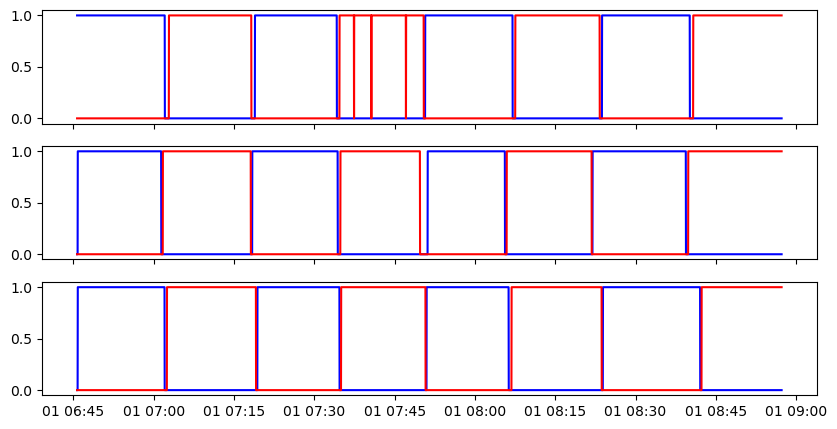

In [7]:
# Create a pandas DataFrame from the drone_id list
t = pd.DataFrame(drone_id)

# Create a figure with 3 subplots and a shared x-axis
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 5), sharex=True)

# Plot data of drones D1 and D2 on position P1
ax1.plot(t[0], t[1], c='blue')
ax1.plot(t[0], t[2], c='red')

# Plot data of drones D3 and D4 on position P2
ax2.plot(t[0], t[3], c='blue')
ax2.plot(t[0], t[4], c='red')

# Plot data of drones D5 and D6 on position P3
ax3.plot(t[0], t[5], c='blue')
ax3.plot(t[0], t[6], c='red')

# Display the plot
plt.show()